# DEM Topographic Analysis

**Study Area:** Gangotri Glacier, Uttarakhand Himalayas (30.92°N, 79.08°E)  
**Analysis Period:** 2000 to 2011 (11 years)  
**Data Sources:**
- SRTM (2000): 30m resolution baseline DEM
- ASTER GDEM (2011): 30m resolution recent DEM

**Objective:** Detect and classify glacier elevation changes using multi-temporal DEM comparison

In [1]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings
import pickle
import os
warnings.filterwarnings('ignore')
np.random.seed(42)

try:
    ee.Initialize()
    print("Earth Engine already initialized!")
except:
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine initialized successfully!")

Earth Engine already initialized!


In [2]:
lon = 79.08
lat = 30.92
roi = ee.Geometry.Point([lon, lat]).buffer(10000)

srtm = ee.Image('USGS/SRTMGL1_003').select('elevation')
aster = ee.Image('NASA/ASTER_GED/AG100_003').select('elevation')

print(f"Study Area: Gangotri Glacier, Uttarakhand ({lat}°N, {lon}°E), 10km buffer")
print("Time Period: 2000 (SRTM) → 2011 (ASTER GDEM)")

Study Area: Gangotri Glacier, Uttarakhand (30.92°N, 79.08°E), 10km buffer
Time Period: 2000 (SRTM) → 2011 (ASTER GDEM)


In [3]:
dem_2000 = srtm.clip(roi)
dem_2011 = aster.clip(roi)
elevation_change = dem_2011.subtract(dem_2000)

dem_2000 = dem_2000.rename('elev_2000')
dem_2011 = dem_2011.rename('elev_2011')
elevation_change = elevation_change.rename('elev_change')

slope = ee.Terrain.slope(aster.clip(roi)).rename('slope')
aspect = ee.Terrain.aspect(aster.clip(roi)).rename('aspect')
hillshade = ee.Terrain.hillshade(aster.clip(roi)).rename('hillshade')

stack = dem_2000.addBands(dem_2011).addBands(elevation_change).addBands(slope).addBands(aspect).addBands(hillshade)
print(f"Features: {stack.bandNames().getInfo()}")

Features: ['elev_2000', 'elev_2011', 'elev_change', 'slope', 'aspect', 'hillshade']


In [4]:
Map = geemap.Map(center=[lat, lon], zoom=12)

dem_vis = {'min': 4000, 'max': 8000, 'palette': ['blue', 'cyan', 'green', 'yellow', 'orange', 'red', 'white']}
change_vis = {'min': -30, 'max': 30, 'palette': ['red', 'orange', 'white', 'lightblue', 'blue']}

Map.addLayer(dem_2000, dem_vis, 'Elevation 2000', False)
Map.addLayer(dem_2011, dem_vis, 'Elevation 2011', True)
Map.addLayer(elevation_change, change_vis, 'Elevation Change', True)
Map.addLayer(roi, {'color': 'yellow', 'width': 2}, 'Study Area')
Map.add_colorbar(change_vis, label='Elevation Change (m)', orientation='horizontal')
Map

Map(center=[30.92, 79.08], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

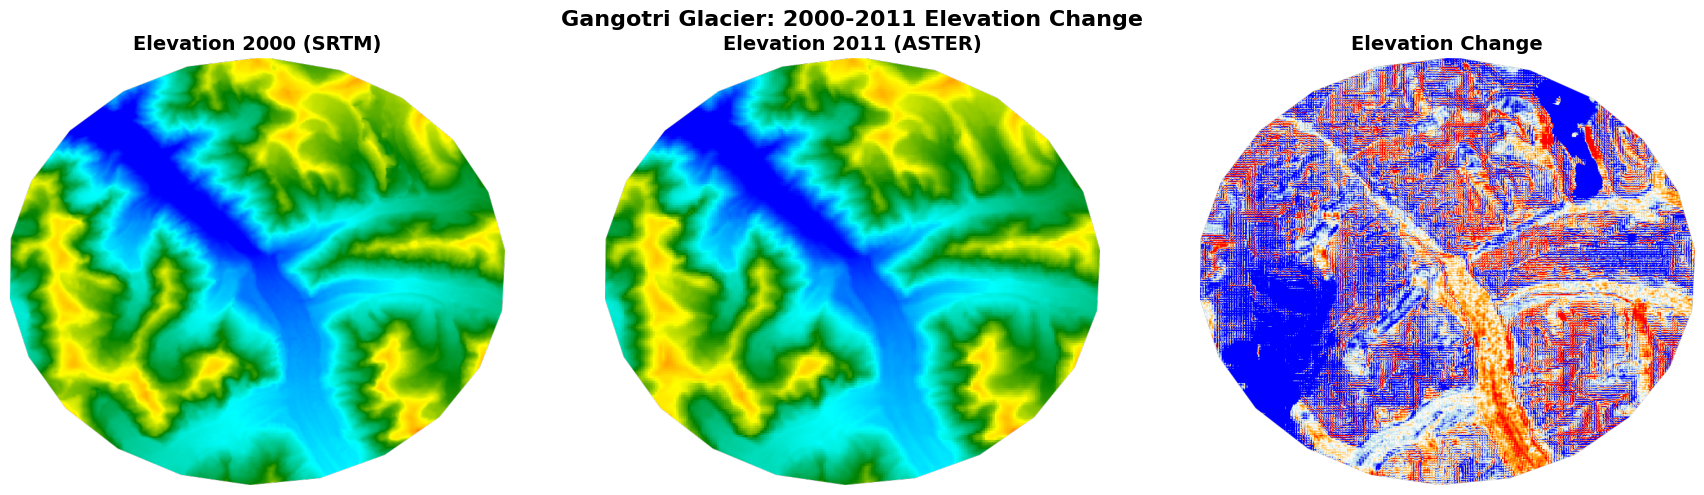

In [5]:
import requests
from io import BytesIO
from PIL import Image

thumbnail_params = {'region': roi, 'dimensions': 800, 'format': 'png'}
dem_2000_thumb = dem_2000.visualize(**dem_vis).getThumbURL(thumbnail_params)
dem_2011_thumb = dem_2011.visualize(**dem_vis).getThumbURL(thumbnail_params)
change_thumb = elevation_change.visualize(**change_vis).getThumbURL(thumbnail_params)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Elevation 2000 (SRTM)', 'Elevation 2011 (ASTER)', 'Elevation Change']
thumbs = [dem_2000_thumb, dem_2011_thumb, change_thumb]

for ax, title, thumb_url in zip(axes, titles, thumbs):
    response = requests.get(thumb_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle('Gangotri Glacier: 2000-2011 Elevation Change', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
sample = stack.sample(region=roi, scale=90, numPixels=2000, seed=42, geometries=False)
sample_list = sample.getInfo()['features']

data = [feature['properties'] for feature in sample_list]
df = pd.DataFrame(data).dropna()

print(f"Samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nElevation Change Statistics:")
print(f"  Mean: {df['elev_change'].mean():.2f}m")
print(f"  Std: {df['elev_change'].std():.2f}m")
print(f"  Range: {df['elev_change'].min():.2f}m to {df['elev_change'].max():.2f}m")
print(f"\nSample data range:")
print(f"  2000: {df['elev_2000'].min():.0f}m to {df['elev_2000'].max():.0f}m")
print(f"  2011: {df['elev_2011'].min():.0f}m to {df['elev_2011'].max():.0f}m")

Samples: 1983
Columns: ['aspect', 'elev_2000', 'elev_2011', 'elev_change', 'hillshade', 'slope']

Elevation Change Statistics:
  Mean: 18.53m
  Std: 53.17m
  Range: -178.00m to 429.00m

Sample data range:
  2000: 3473m to 6556m
  2011: 3477m to 6640m


In [7]:
q25 = df['elev_change'].quantile(0.25)
q50 = df['elev_change'].quantile(0.50)
q75 = df['elev_change'].quantile(0.75)

df['class'] = 0
df.loc[df['elev_change'] > q25, 'class'] = 1
df.loc[df['elev_change'] > q50, 'class'] = 2
df.loc[df['elev_change'] > q75, 'class'] = 3

labels = ['Major Thinning', 'Moderate Thinning', 'Slight Change', 'Stable']
print(f"\nClass Thresholds:")
print(f"  0: < {q25:.2f}m | 1: {q25:.2f}-{q50:.2f}m | 2: {q50:.2f}-{q75:.2f}m | 3: > {q75:.2f}m")
print(f"\nDistribution: {df['class'].value_counts().sort_index().to_dict()}")


Class Thresholds:
  0: < -9.00m | 1: -9.00-9.00m | 2: 9.00-34.00m | 3: > 34.00m

Distribution: {0: 507, 1: 516, 2: 473, 3: 487}


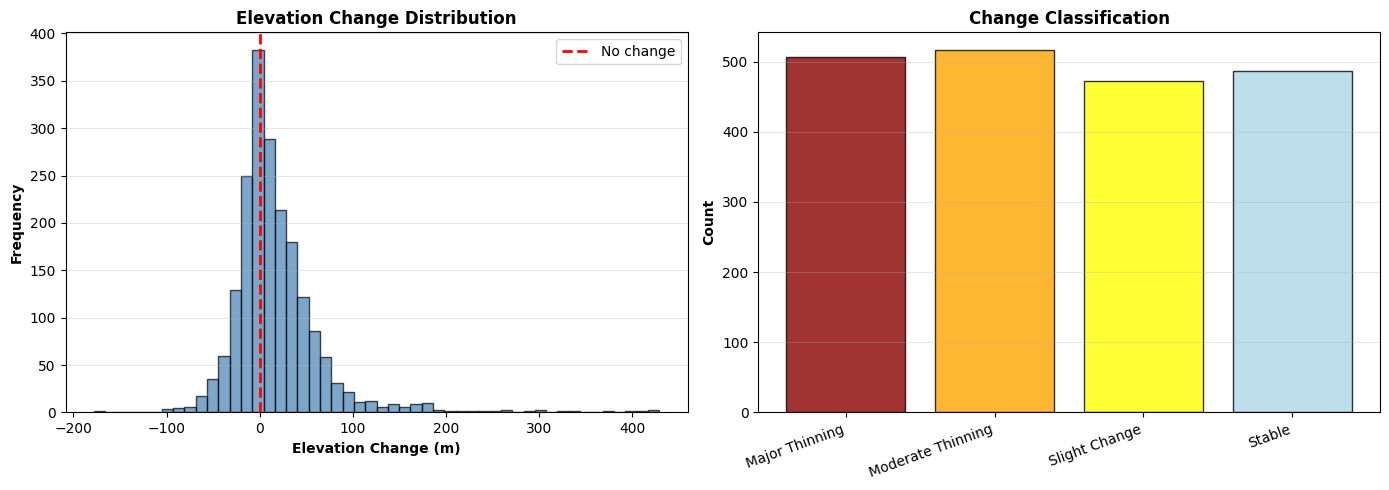

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['elev_change'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
axes[0].set_xlabel('Elevation Change (m)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Elevation Change Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

class_counts = df['class'].value_counts().sort_index()
colors = ['darkred', 'orange', 'yellow', 'lightblue']
axes[1].bar(range(len(class_counts)), class_counts.values, 
           color=[colors[i] for i in class_counts.index], edgecolor='black', alpha=0.8)
axes[1].set_xticks(range(len(class_counts)))
axes[1].set_xticklabels([labels[i] for i in class_counts.index], rotation=20, ha='right')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Change Classification', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
df['slope_flat'] = (df['slope'] < 10).astype(int)
df['slope_moderate'] = ((df['slope'] >= 10) & (df['slope'] < 30)).astype(int)
df['slope_steep'] = (df['slope'] >= 30).astype(int)
df['aspect_sin'] = np.sin(np.radians(df['aspect']))
df['aspect_cos'] = np.cos(np.radians(df['aspect']))

# DO NOT include elev_change as a feature - that's what we're predicting!
feature_cols = ['slope', 'aspect', 'hillshade',
                'slope_flat', 'slope_moderate', 'slope_steep',
                'aspect_sin', 'aspect_cos']

X = df[feature_cols].values
y = df['class'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Features: {len(feature_cols)} | Train: {len(X_train)} | Test: {len(X_test)}")

Features: 8 | Train: 1388 | Test: 595


In [10]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
    'SVM': SVC(kernel='rbf', C=10, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_temp = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    results[name] = {'model': model, 'accuracy': acc, 'predictions': y_pred_temp}
    print(f"{name}: {acc*100:.2f}%")

best_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_name]['model']
y_pred = results[best_name]['predictions']

print(f"\nBest: {best_name}")

Random Forest: 34.45%
SVM: 35.97%
KNN: 32.77%

Best: SVM


In [11]:
print(classification_report(y_test, y_pred, target_names=labels))

                   precision    recall  f1-score   support

   Major Thinning       0.36      0.32      0.34       152
Moderate Thinning       0.52      0.29      0.37       155
    Slight Change       0.25      0.32      0.28       142
           Stable       0.39      0.51      0.44       146

         accuracy                           0.36       595
        macro avg       0.38      0.36      0.36       595
     weighted avg       0.38      0.36      0.36       595



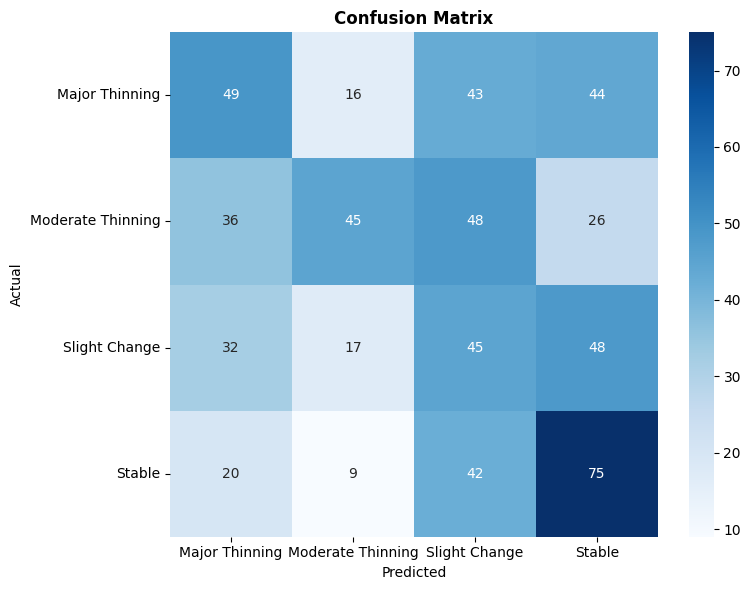

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [13]:
os.makedirs('models', exist_ok=True)

with open('models/DEM_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('models/DEM_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
df.to_csv('models/DEM_data.csv', index=False)

print(f"Saved: models/DEM_model.pkl ({best_name}), models/DEM_scaler.pkl, models/DEM_data.csv")

Saved: models/DEM_model.pkl (SVM), models/DEM_scaler.pkl, models/DEM_data.csv


## Summary

**Study Area:** Gangotri Glacier, Uttarakhand (30.92°N, 79.08°E), 10km buffer

**Time Period:** 2000 to 2011 (11 years)

**Data:**
- SRTM (2000): 30m resolution baseline
- ASTER GDEM (2011): 30m resolution

**Method:**
- Calculate elevation change between 2000 and 2011
- Extract terrain features (slope, aspect, hillshade)
- Classify into 4 categories using quantile-based thresholds
- Train Random Forest, SVM, and KNN models
- 70/30 train-test split with stratified sampling

**Results:**
- Major Thinning: Significant elevation loss
- Moderate Thinning: Moderate retreat
- Slight Change: Minimal variation  
- Stable: Little to no change

**Output:** Model, scaler, and data saved to `datasets/DEM/`